# Colates, cleans and analyses soil heat flux data from Rain shelter barley trail

In [70]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline
import lmfit as fitter
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates

In [71]:
Data = pd.read_pickle('.\DataFrames\TempAndRadnCleaned.pkl')
Data = Data.loc[:'2015-02-24']
SoilTempData = pd.read_pickle('.\DataFrames\SoilTemp.pkl')
SoilWaterData = pd.read_pickle('.\DataFrames\SoilVWC.pkl')
Data.columns = Data.columns.droplevel(level=[3,4,5,6,7])
Data.sort_index(axis=1, inplace = True)
SoilTempData.sort_index(axis=1, inplace = True)
SoilWaterData.sort_index(axis=1, inplace = True)
Data.sort_index(inplace = True)
SoilTempData.sort_index(inplace = True)
SoilWaterData.sort_index(inplace = True)
RadnDataSums = Data.loc[:,Data.columns.isin(['ReflectedRadnMJ','IncomingRadnMJ'],level=0)].resample('15T').sum()
Data = Data.resample('15T').mean()
Data.loc[:,Data.columns.isin(['ReflectedRadnMJ','IncomingRadnMJ'],level=0)] = RadnDataSums

In [72]:
Cultivars = ['Dash','Omaka']
Irrigations = ['High','Low','Mid']
IrrigationsShort = ['High','Low']
BD = 1.1
CW = 4179 # specific heat capacity of water (J/kg/oK)
CD = 840 # specific heat capacity of dry soil (J/kg/oK)
Cs = BD * CD # heat capaacity of dry soil

Styles = ['b--','b--','b--','b--','r--','r--','r--','r--','g--','g--','g--','g--',
          'b-','b-','b-','b-','r-','r-','r-','r-','g-','g-','g-','g-']

Styles2 = ['b--','b--','b--','r--','r--','r--',
          'b-','b-','b-','r-','r-','r-']

# Have a look at the heat flux plate data 

Text(0,0.5,'HeatFlux (W/m2)')

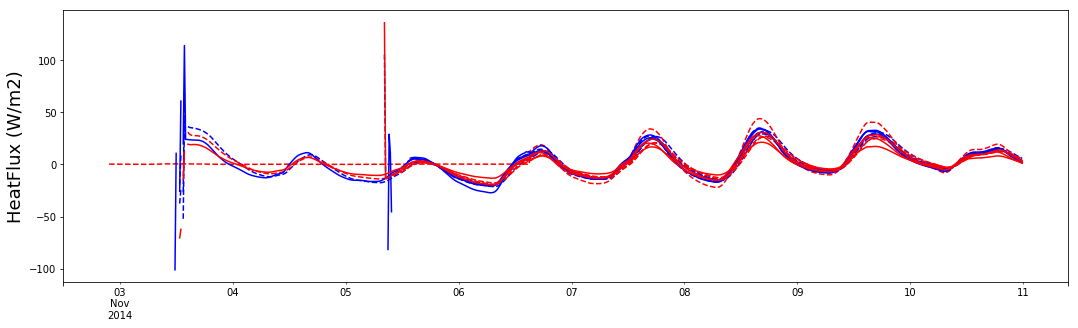

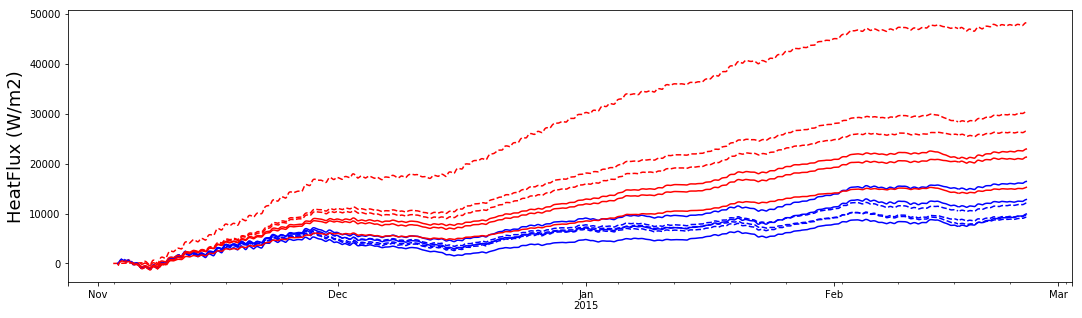

In [73]:
Data.HeatFlux.plot(figsize=(18,5), style = Styles2, legend = False)
plt.ylabel('HeatFlux (W/m2)',fontsize=18)
plt.ylim(-50,50)
Data.HeatFlux.loc['2014-10-1':'2014-11-10'].plot(figsize=(18,5), style = Styles2, legend = False)
plt.ylabel('HeatFlux (W/m2)',fontsize=18)
Data.HeatFlux.cumsum().plot(figsize=(18,5), style = Styles2, legend = False)
plt.ylabel('HeatFlux (W/m2)',fontsize=18)

# There appears to be positive heat flux into the soil and treatment differences 

# Now lets have a look at the soil temperature above the heat flux plates

Text(0,0.5,'Temperature (oC)')

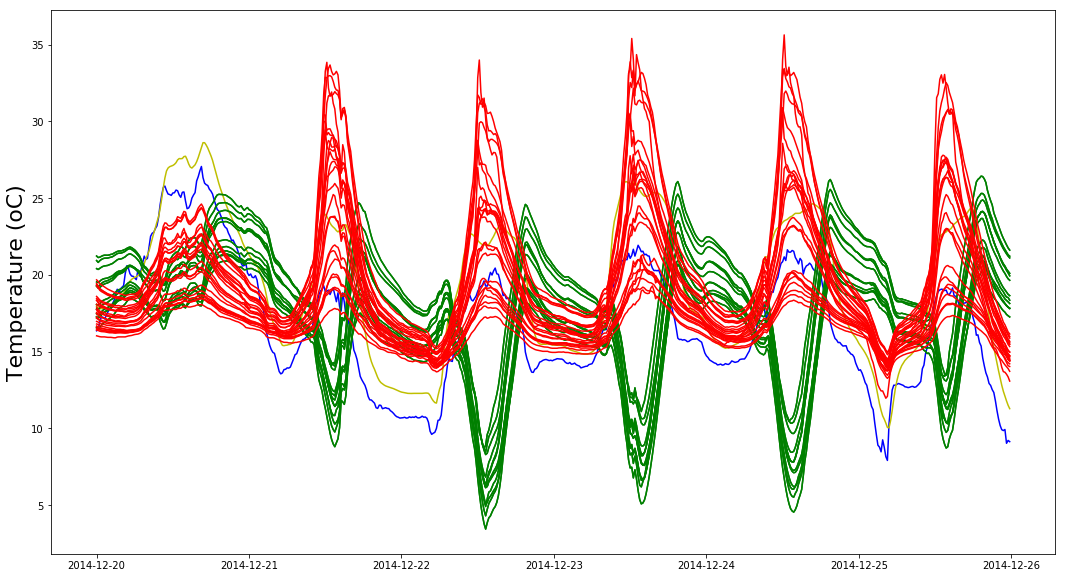

In [74]:
Start = '2014-12-20'
End ='2014-12-25'
figure = plt.figure(figsize=(18,10))
plt.plot(Data.AirTemperature.loc[Start:End], color = 'b')
plt.plot(Data.PannelTemperature.loc[Start:End], color = 'y')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SurfaceSoilTemp.loc[Start:End], color = 'r')
plt.ylabel('Temperature (oC)',fontsize=22)
#plt.plot(TopTempDF.loc[Start:End], color = 'k')

# Averaging thermocouple data is shit.  Use temp from cs650 instead

# Get the soil temperatue data for the top 15cm 

Text(0,0.5,'Temperature (oC)')

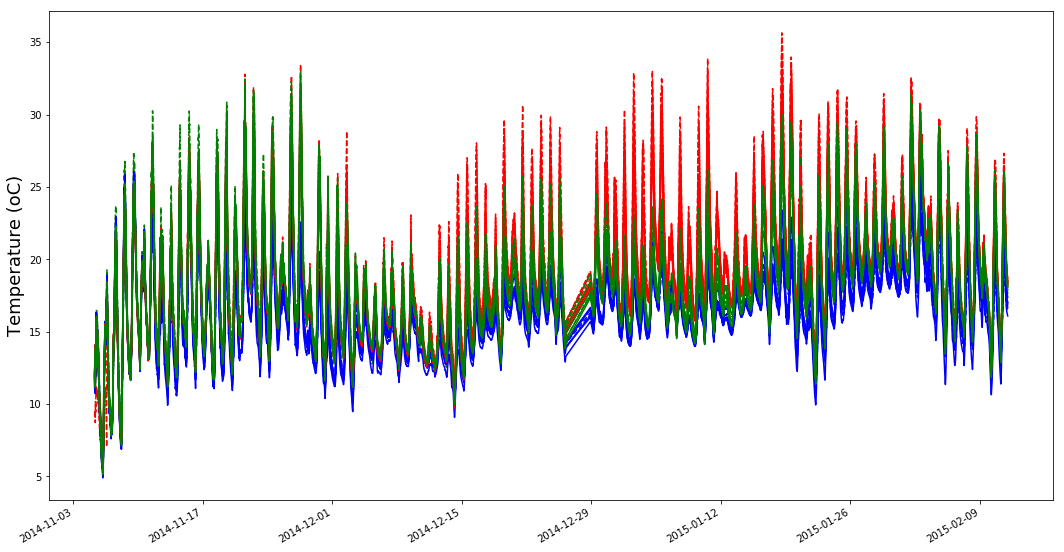

In [75]:
TopTemp = np.add(SoilTempData.loc[:'2015-02-11','D1B'].values,SoilTempData.loc[:'2015-02-11','D1I'].values)
TopTemp /= 2
TopTemp = np.add(TopTemp,SoilTempData.loc[:'2015-02-11','D2'].values)
TopTemp /= 2

tup = ['TopTemp']
reps = [1,2,3,4]
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations,reps],names=['Measurement','Cultivar','Irrigation',''])
#NewIndex = NewIndex.droplevel(3)
TopTempDF = pd.DataFrame(data = TopTemp, index = SoilTempData.loc[:'2015-02-11',:].index, columns = NewIndex)

TopTempDF.plot(figsize=(18,10),style=Styles, legend = False)
plt.ylabel('Temperature (oC)',fontsize=18)
TopTempDF.loc['2014-12-1':'2014-12-5'].plot(figsize=(18,10),style=Styles, legend = False)
plt.ylabel('Temperature (oC)',fontsize=18)

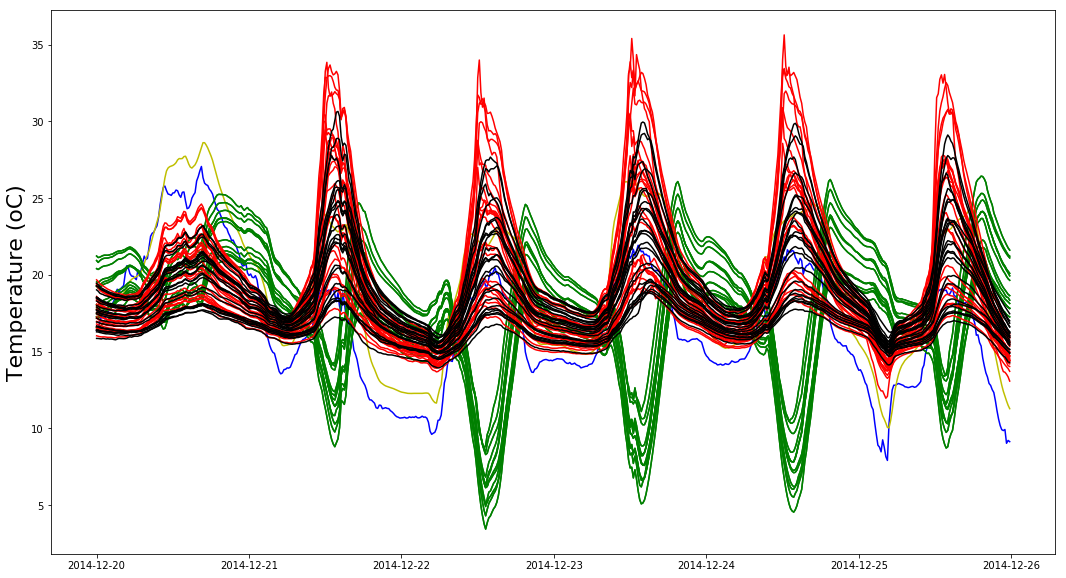

In [76]:
Start = '2014-12-20'
End ='2014-12-25'
figure = plt.figure(figsize=(18,10))
plt.plot(Data.AirTemperature.loc[Start:End], color = 'b')
plt.plot(Data.PannelTemperature.loc[Start:End], color = 'y')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SurfaceSoilTemp.loc[Start:End], color = 'r')
plt.ylabel('Temperature (oC)',fontsize=22)
plt.plot(TopTempDF.loc[Start:End], color = 'k')

# The CS650 data is better so use that.

# Bring in the soil water data for the top layer

Text(0,0.5,'Volumetric Water Content (mm/mm)')

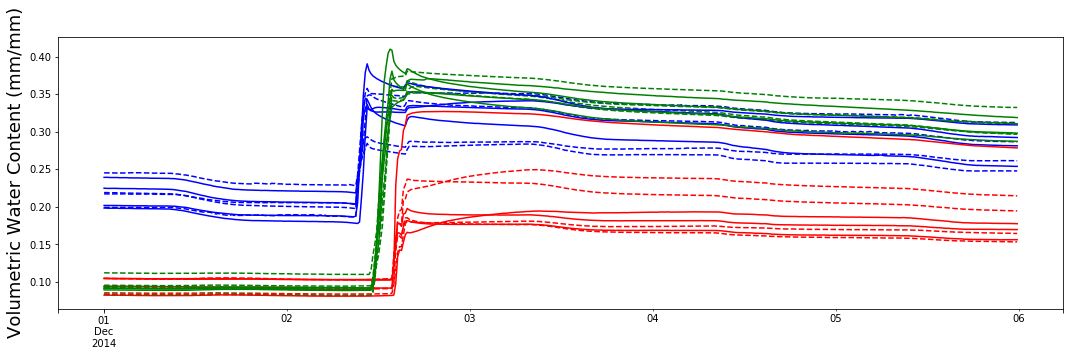

In [77]:
TopWater = np.add(SoilWaterData.loc[:'2015-02-11','D1B'].values,SoilWaterData.loc[:'2015-02-11','D1I'].values)
TopWater /=2
TopWater *= 1/BD

tup = ['TopWater']
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations,reps],names=['Measurement','Cultivar','Irrigation',''])
#NewIndex = NewIndex.droplevel(3)
TopWaterDF = pd.DataFrame(data = TopWater, index = SoilWaterData.loc[:'2015-02-11'].index, columns = NewIndex)

TopWaterDF.plot(figsize=(18,5),style=Styles, legend=False)
plt.ylabel('Volumetric Water Content (mm/mm)',fontsize=18)
TopWaterDF.loc['2014-12-1':'2014-12-5'].plot(figsize=(18,5),style=Styles, legend=False)
plt.ylabel('Volumetric Water Content (mm/mm)',fontsize=18)

# Calculate the specific heat capacity of soils

Text(0,0.5,'Soil Heat capacity (J/oc/kg)')

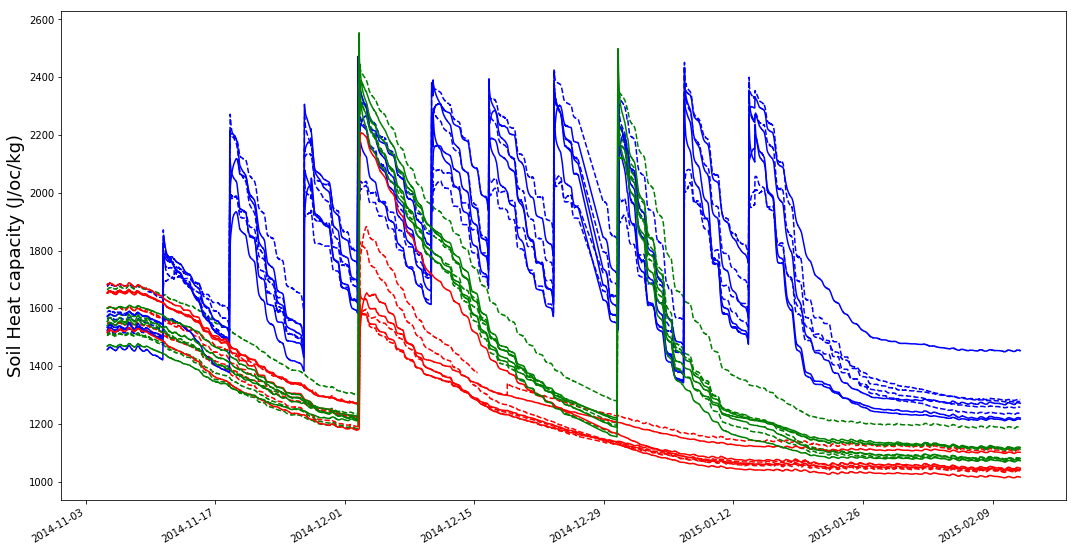

In [78]:
Cw = np.multiply(TopWater,CW)
Cs = np.add(Cw,CD)

tup = ['Cs']
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations,[1,2,3,4]],names=['Measurement','Cultivar','Irrigation',''])
NewIndex = NewIndex.droplevel(3)
CsDF = pd.DataFrame(data = Cs, index = SoilWaterData.index, columns = NewIndex)

CsDF.plot(figsize=(18,10),style=Styles, legend = False)
plt.ylabel('Soil Heat capacity (J/oc/kg)',fontsize=18)

## Calculate temperature deltas

Text(0,0.5,'Temperature Delta(oC)')

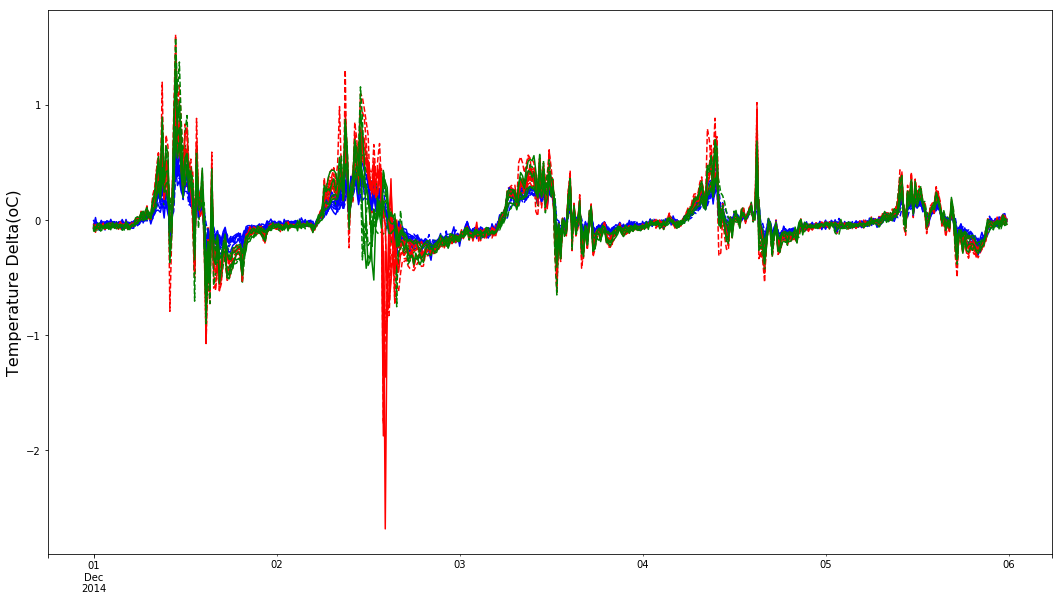

In [79]:
DeltaTemp = TopTempDF.diff()
DeltaTemp.plot(figsize=(18,10),style=Styles, legend = False)
plt.ylabel('Temperature Delta(oC)',fontsize=16)
DeltaTemp.loc['2014-12-1':'2014-12-5'].plot(figsize=(18,10),style=Styles, legend=False)
plt.ylabel('Temperature Delta(oC)',fontsize=16)

# Calculate energy stored in soil above heat flux plates

Text(0,0.5,'Top Layer Energy storage (MJ)')

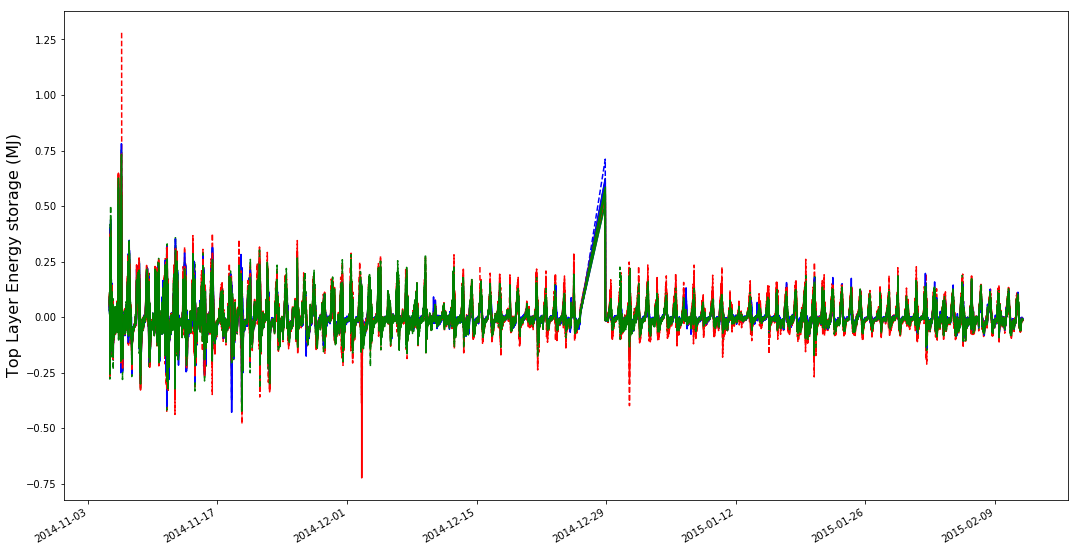

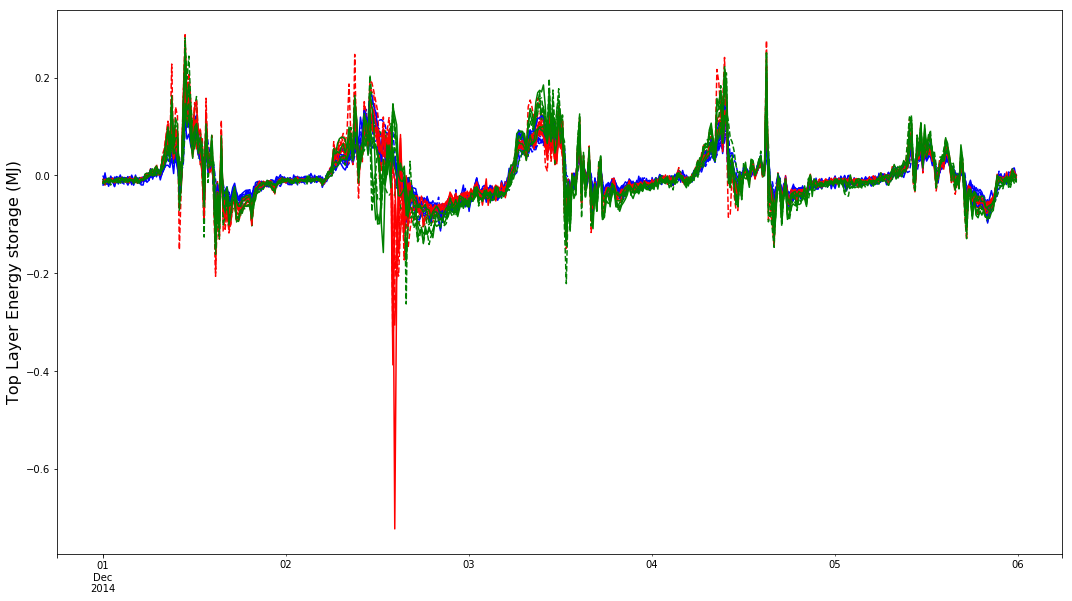

In [80]:
#Calculate the joules of energy stored in the soil per kg of soil
EnergyStored = np.multiply(DeltaTemp.values, CsDF.values) 
#Adjust for soil depth to give joules in the top 150 mm
EnergyStored = np.multiply(EnergyStored,150)
#Convert to MJ
EnergyStored = np.divide(EnergyStored,1000000)

tup = ['S']
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations,[1,2,3,4]],names=['Measurement','Cultivar','Irrigation',''])
TopEnergy = pd.DataFrame(data = EnergyStored, index = SoilWaterData.index, columns = NewIndex)

TopEnergy.plot(figsize=(18,10),style=Styles, legend=False)
plt.ylabel('Top Layer Energy storage (MJ)',fontsize=16)
TopEnergy.loc['2014-12-1':'2014-12-5'].plot(figsize=(18,10),style=Styles,legend=False)
plt.ylabel('Top Layer Energy storage (MJ)',fontsize=16)
TopEnergy.cumsum().plot(figsize=(18,10),style=Styles, legend=False)
plt.ylabel('Top Layer Energy storage (MJ)',fontsize=16)

### subset of plots where heat flux was measured

In [81]:
SoilHeat = TopEnergy.loc[:,[('S','Dash','High',1),('S','Dash','High',3),('S','Dash','High',4),
          ('S','Dash','Low',1),('S','Dash','Low',3),('S','Dash','Low',4),
          ('S','Omaka','High',1),('S','Omaka','High',3),('S','Omaka','High',4),
          ('S','Omaka','Low',1),('S','Omaka','Low',2),('S','Omaka','Low',4),]]

SoilHeat.columns = SoilHeat.columns.droplevel(3)

#Index dates when soil temp was measured
DateIndex = SoilHeat.index.tolist()

# Convert instantatious heat flux to Accumulated energy (W - MJ)

Text(0,0.5,'Deep Soil Heat Flux (MJ)')

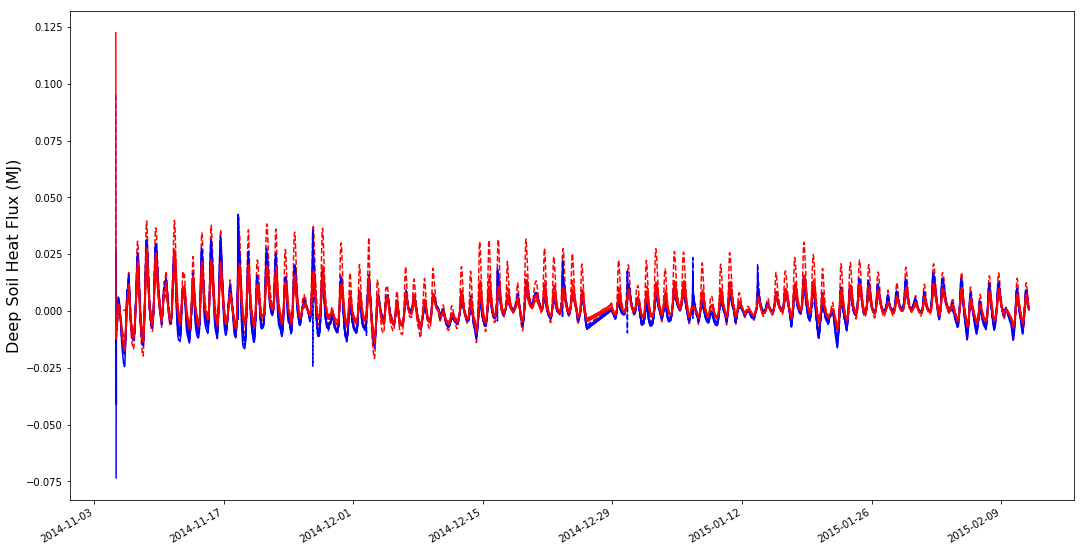

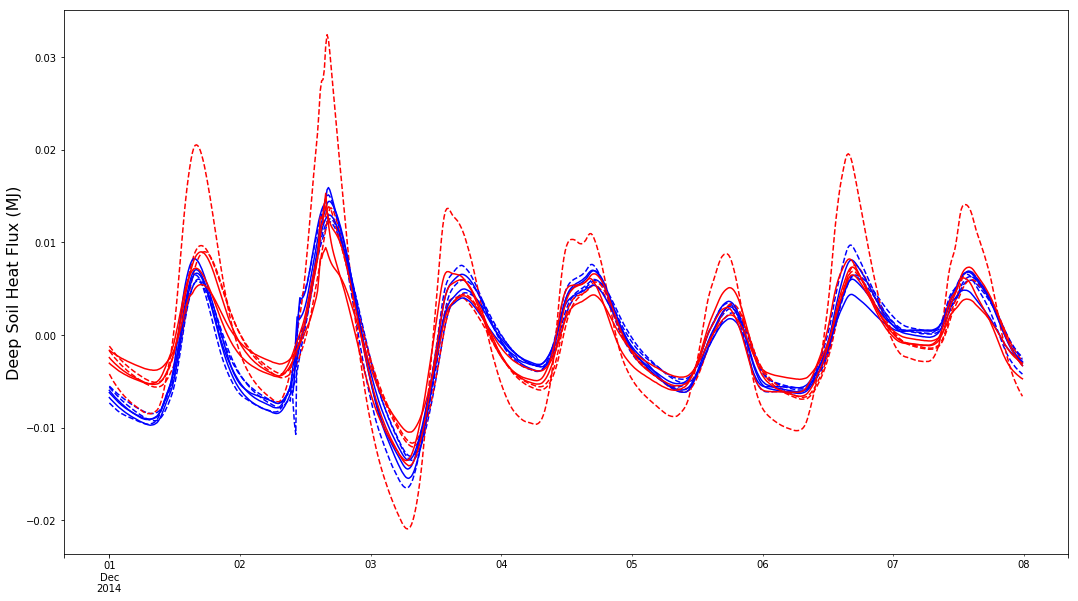

In [82]:
#Multiply by the duration of the measurement period to go from W/m2 to J/m2
HeatFluxMJ = np.multiply(Data.HeatFlux.loc[DateIndex,:].values,900)
#divide by a million to conver to JM
HeatFluxMJ = np.divide(HeatFluxMJ,1000000)

tup = ['HeatFluxMJ']
Irrigs = ['High','Low']
reps = [1,2,3]
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigs,reps],names=['Measurement','Cultivar','Irrigation',''])
NewIndex = NewIndex.droplevel(3)
HeatFluxDF = pd.DataFrame(data = HeatFluxMJ, index = Data.loc[DateIndex,:].index, columns = NewIndex)

HeatFluxDF.plot(figsize=(18,10),style=Styles2, legend=False)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=16)
HeatFluxDF.loc['2014-12-1':'2014-12-7'].plot(figsize=(18,10),style=Styles2, legend=False)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=16)
HeatFluxDF.cumsum().plot(figsize=(18,10),style=Styles2, legend=False)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=16)

# Add the two heat fluxes together to give total heat flux to the soil

In [83]:
DaylightIndex = Data.IncomingRadnMJ.where(Data.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or 

Text(0,0.5,'Soil Heat Flux (W/m2)')

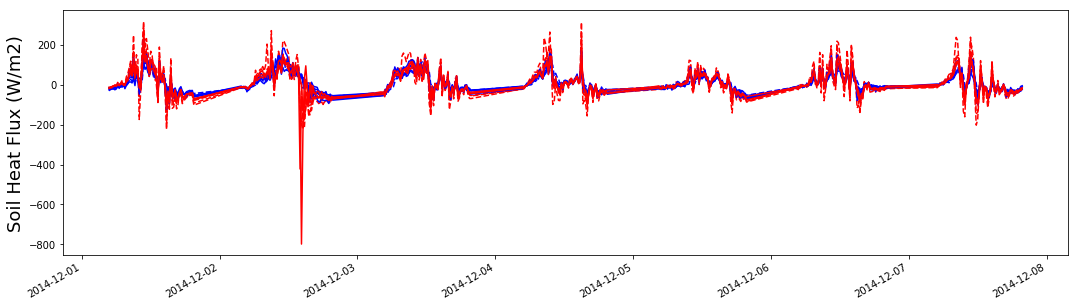

In [84]:
#Add total energy fluxes together
SoilHeatFluxMJ = np.add(HeatFluxDF.values,SoilHeat.values)
#Divide by the duration of the measurement period to make instanious (MJ/m2 to MW/m2)
SoilHeatFluxMW = np.divide(SoilHeatFluxMJ,900)
#Multiply by a million to go from MW/m2 to W/m2
SoilHeatFluxW = np.multiply(SoilHeatFluxMW,1000000)

IndexTups =  [('SoilHeat','Dash','High','1'),('SoilHeat','Dash','High','3'),('SoilHeat','Dash','High','4'),
          ('SoilHeat','Dash','Low','1'),('SoilHeat','Dash','Low','3'),('SoilHeat','Dash','Low','4'),
          ('SoilHeat','Omaka','High','1'),('SoilHeat','Omaka','High','3'),('SoilHeat','Omaka','High','4'),
          ('SoilHeat','Omaka','Low','1'),('SoilHeat','Omaka','Low','2'),('SoilHeat','Omaka','Low','4')]
NewIndex = pd.MultiIndex.from_tuples(IndexTups,names=['Var','Cultivar','Irrigation','Block'])
SoilHeatFluxMJ = pd.DataFrame(data = SoilHeatFluxMJ, index = Data.ix[DateIndex,:].index, columns = NewIndex)
SoilHeatFluxW = pd.DataFrame(data = SoilHeatFluxW, index = Data.ix[DateIndex,:].index, columns = NewIndex)

SoilHeatFluxW.ix[DaylightIndex,:].plot(figsize=(18,10),style=Styles2, legend=False)
plt.ylabel('Soil Heat Flux (W/m2)', fontsize = 18)
plt.ylim(-500,500)
SoilHeatFluxW.ix[DaylightIndex,:].ix['2014-12-1':'2014-12-7'].plot(figsize=(18,5),style=Styles2, legend=False)
plt.ylabel('Soil Heat Flux (W/m2)', fontsize = 18)
SoilHeatFluxW.cumsum().plot(figsize=(18,5),style=Styles2, legend=False)
plt.ylabel('Soil Heat Flux (W/m2)', fontsize = 18)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


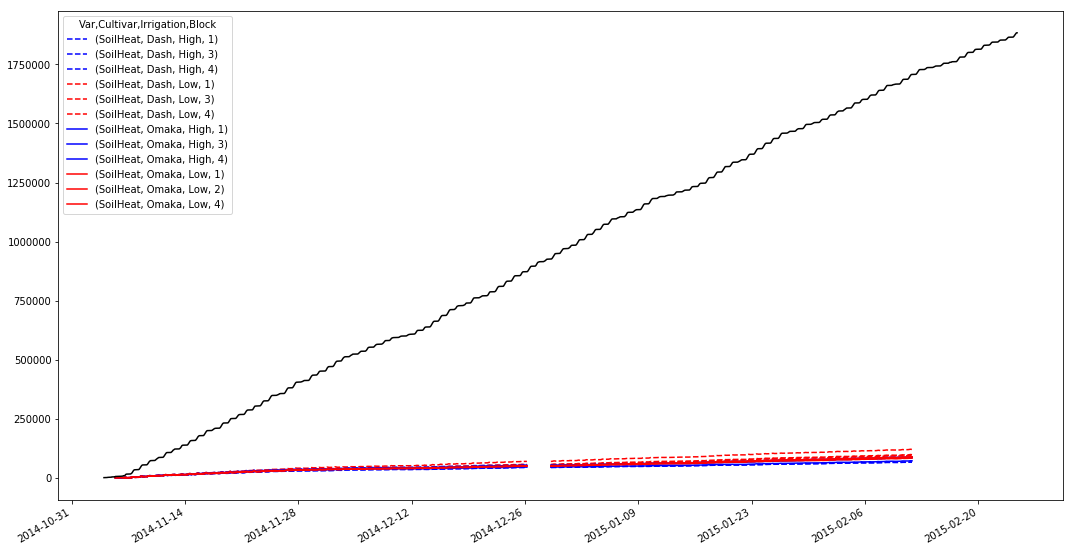

In [85]:
Styles = ['b--','b--','b--','r--','r--','r--',
          'b-','b-','b-','r-','r-','r-']
SoilHeatFluxW.loc[DaylightIndex,:].cumsum().plot(figsize=(18,10),style=Styles)
#Plot incoming net radiation (taking total radiation, converting to W and multiplying by 0.66 to give net radn)
plt.plot(Data.IncomingRadnKW.loc[DaylightIndex].index,Data.IncomingRadnKW.loc[DaylightIndex].multiply(1000*0.66).cumsum(),'-',color='k',label='Incomming Radn')

# Relative to incoming energy, Soil heat flux is quite small over the duration of the experiment

In [86]:
SoilHeatFluxW.columns = SoilHeatFluxW.columns.droplevel('Var')

In [87]:
SoilHeatFluxW.index.name = 'Date'
SoilHeatFluxWLong = SoilHeatFluxW.resample('h').mean().unstack()
SoilHeatFluxWLong.name = 'G'
SoilHeatFluxWLong.to_pickle('.\DataFrames\HourlySoilHeatFluxTotalW.pkl')
#SoilHeatFluxMJ.resample('h').sum().to_pickle('.\DataFrames\HourlySoilHeatFluxTotalMJ.pkl')

NightIndex = SoilHeatFluxW.index.indexer_between_time(datetime.time(23),
                    datetime.time(4))
SoilHeatFluxW.iloc[NightIndex,:].resample('h').mean().to_pickle('.\DataFrames\HourlySoilHeatFluxDarkW.pkl')
SoilHeatFluxMJ.iloc[NightIndex,:].resample('h').sum().to_pickle('.\DataFrames\HourlySoilHeatFluxDarkMJ.pkl')
SoilHeatFluxMJ.iloc[NightIndex,:].resample('h').sum().divide(2.4).to_pickle('.\DataFrames\HourlySoilHeatFluxDark_mm.pkl')

In [88]:
SoilHeatFluxMJ.index.name='Date'
SoilHeatFluxMJ.columns = SoilHeatFluxMJ.columns.droplevel('Var')
SoilHeatFluxMJLong = SoilHeatFluxMJ.resample('h').sum().unstack()
SoilHeatFluxMJLong.name = 'G'
SoilHeatFluxMJLong.to_pickle('.\DataFrames\HourlySoilHeatFluxTotalMJ.pkl')

# Look at soil heaf flux relative to incomming radiation

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


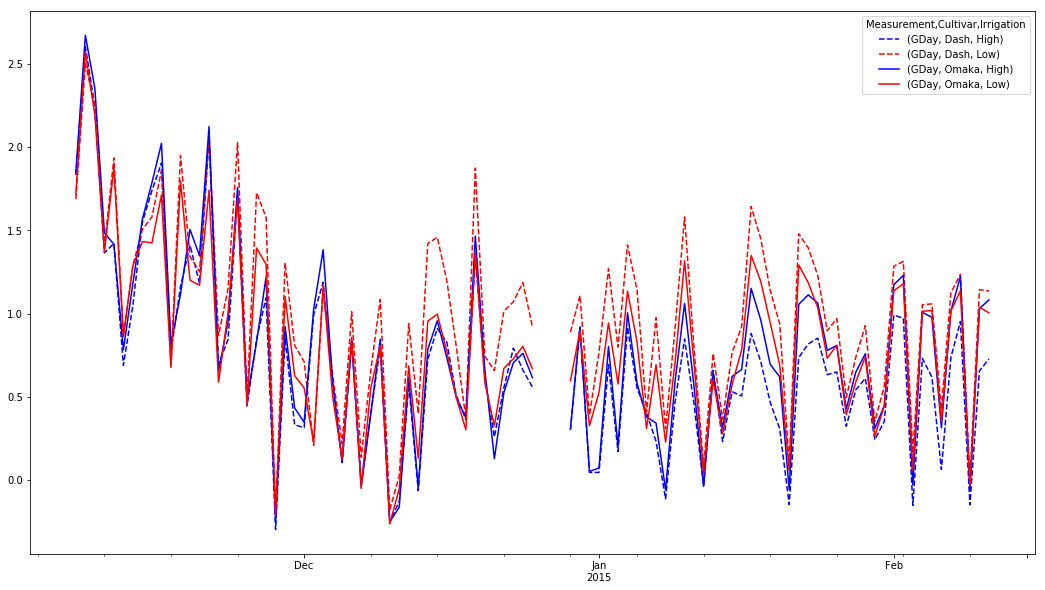

In [89]:
SoilHeatFluxMJMeans = SoilHeatFluxMJ.groupby(level=['Cultivar','Irrigation'],axis=1).mean()
SoilHeatFluxMJDaylightMeans = SoilHeatFluxMJMeans.loc[DaylightIndex,:].resample('24h',base=6).sum()
SoilHeatFluxMJDaylightMeans.index = SoilHeatFluxMJDaylightMeans.index.normalize()
IncommingRadnDaylight = Data.IncomingRadnMJ.loc[DateIndex,:].loc[DaylightIndex,:].resample('24h',base=6).sum() 
IncommingRadnDaylight.index = IncommingRadnDaylight.index.normalize()

GDay = SoilHeatFluxMJDaylightMeans.values

tup = ['GDay']
Irrigs = ['High','Low']
reps = [1,2,3]
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigs],names=['Measurement','Cultivar','Irrigation'])
GDayDF = pd.DataFrame(data = GDay, index = IncommingRadnDaylight.index, columns = NewIndex)
GDayDF.loc[pd.to_datetime(['2014-12-26 00:00:00',
                           '2014-12-27 00:00:00',
                           '2014-12-28 00:00:00',
                           '2015-02-12 00:00:00',
                           '2015-02-13 00:00:00',
                            '2015-02-14 00:00:00',
                            '2015-02-15 00:00:00',
                            '2015-02-16 00:00:00',
                            '2015-02-17 00:00:00',
                            '2015-02-18 00:00:00',
                            '2015-02-19 00:00:00',
                            '2015-02-20 00:00:00',
                            '2015-02-21 00:00:00',
                            '2015-02-22 00:00:00',
                            '2015-02-23 00:00:00',
                            '2015-02-24 00:00:00']),:] = np.nan
GDayDF.loc['2014-11-07':].plot(figsize=(18,10),style=['b--','r--','b-','r-'])
#GDayDF.loc['2014-12-1':'2014-12-7'].groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(figsize=(18,10),style=['b--','r--','b-','r-'])

### Bring in radiation interception data

In [90]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPARTot.pkl')
CoverDataMeans = CoverData.groupby(level=('Cultivar','Irrigation'),axis=1).mean()

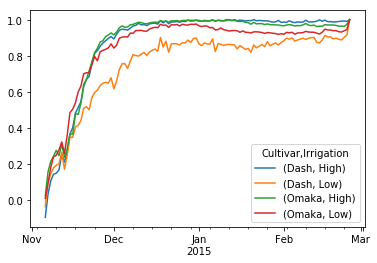

In [91]:
CoverDataMeans.plot()

## Make a data frame for comparing GRn with other variables

In [92]:
def SliceFullPlots(CompleteData,Variable):
    Chunk = CompleteData.loc[:,Variable]
    NewIndex = pd.MultiIndex.from_product([Cultivars,['Low','Mid','High'],[1,2,3,4]],names=['Cultivar','Irrigation',''])
    Chunk.columns = NewIndex
    SubIndex = pd.MultiIndex.from_product([Cultivars,['Low','High'],[1,3,4]],names=['Cultivar','Irrigation',''])
    SubChunk = Chunk.loc[DaylightIndex,SubIndex]
    SubChunkGroup = SubChunk.groupby(level=('Cultivar','Irrigation'), axis=1).mean()
    SubChunkAgregate = SubChunkGroup.resample('24h',base=6).mean()
    SubChunkAgregate.index = SubChunkAgregate.index.normalize()
    SubChunkUnstack = SubChunkAgregate.unstack()
    return SubChunkUnstack
    

In [93]:
LongG = GDayDF.loc[:,('GDay')].unstack(0)
LongData = pd.DataFrame(LongG, columns = ['GDay'])
for cul in Cultivars:
    for irr in IrrigationsShort:
        LongData.loc[(cul,irr),'AirTemperature'] = Data.loc[DaylightIndex,'AirTemperature'].resample('24h',base=6).mean().values
        LongData.loc[(cul,irr),'RelativeHumidity'] = Data.loc[DaylightIndex,'RelativeHumidity'].resample('24h',base=6).mean().values
        LongData.loc[(cul,irr),'Windspeed'] = Data.loc[DaylightIndex,'Windspeed'].resample('24h',base=6).mean().values
        LongData.loc[(cul,irr),'IncomingRadnMJ'] = Data.loc[DaylightIndex,'IncomingRadnMJ'].resample('24h',base=6).sum().values

LongData.loc[:,'fPAR'] = CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().unstack()
LongData.loc[:,'SurfaceSoilTemp'] = SliceFullPlots(Data,'SurfaceSoilTemp')
LongData.loc[:,'TempAirSoil1Diff'] = LongData.loc[:,'AirTemperature'] - SliceFullPlots(Data,'SurfaceSoilTemp') 
SubIndex = pd.MultiIndex.from_product([['TopTemp'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopTempDF.loc[DaylightIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongData.loc[:,'SoilTemp15'] = Temp.unstack()
LongData.loc[:,'TempAirSoil15Diff'] = LongData.loc[:,'AirTemperature'] - LongData.loc[:,'SoilTemp15'] 
SubIndex = pd.MultiIndex.from_product([['TopWater'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopWaterDF.loc[DaylightIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongData.loc[:,'SoilWater'] = Temp.unstack()
LongData.loc[:,'SoilRad'] = LongData.loc[:,'IncomingRadnMJ']* (1-LongData.loc[:,'fPAR'])

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


## Look at heat flux against different variables

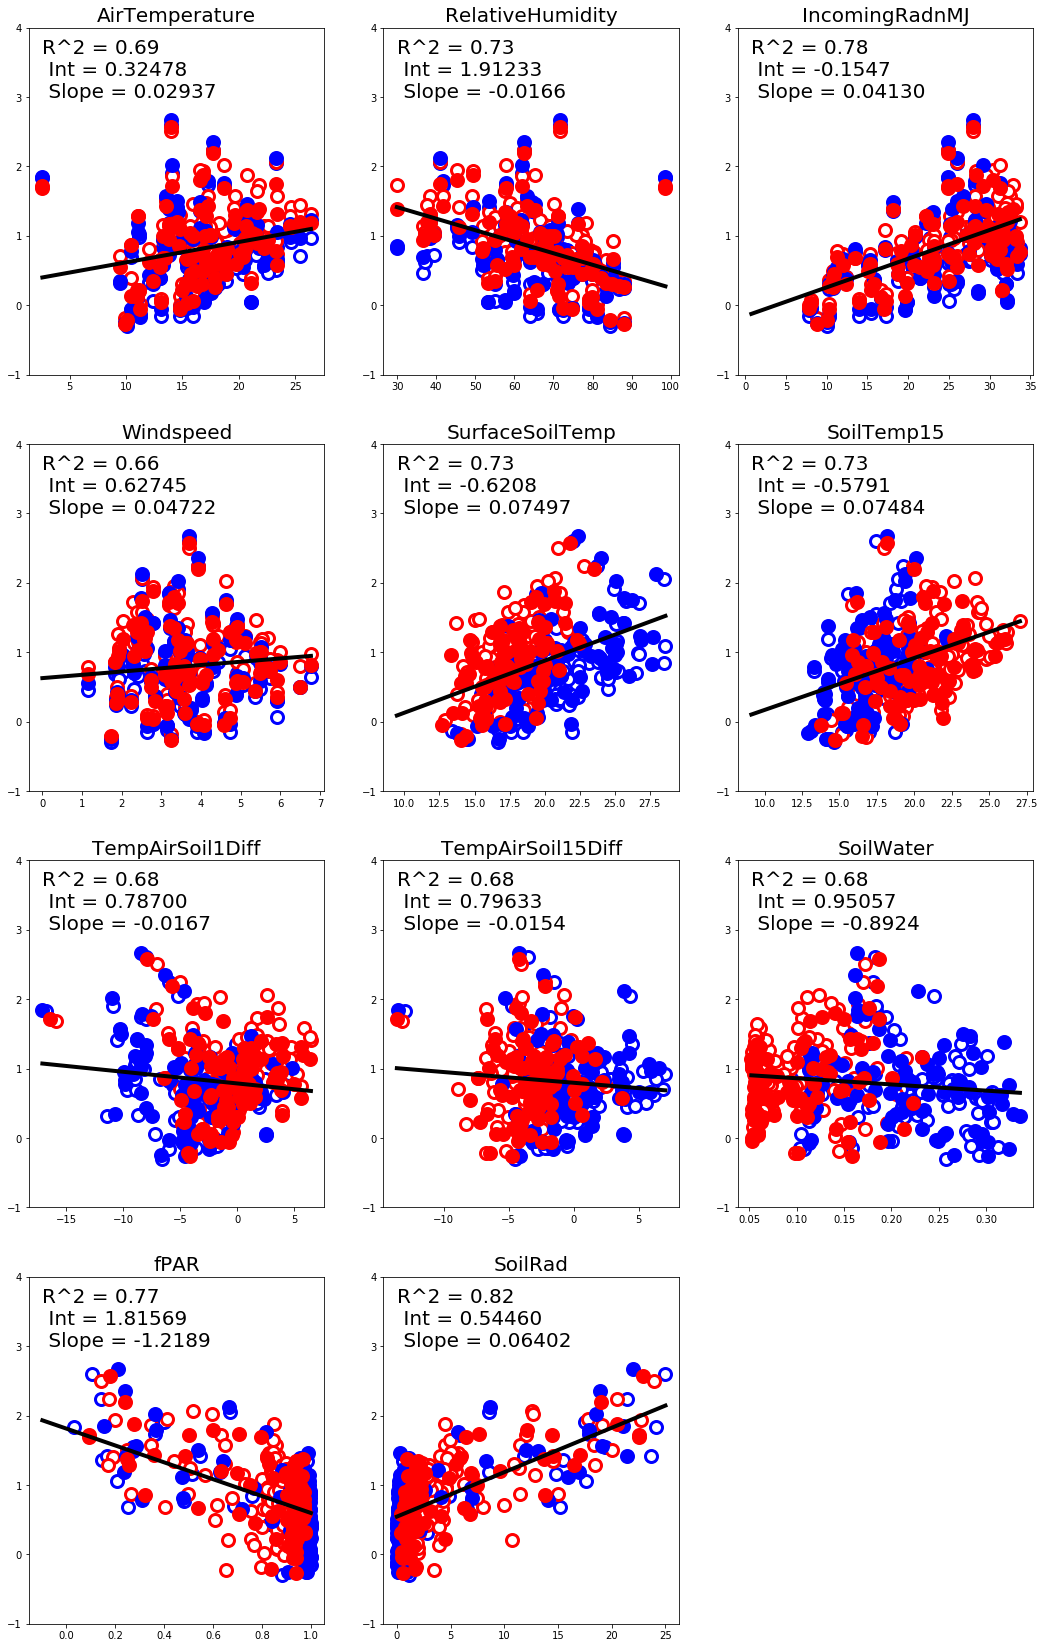

<Figure size 1296x720 with 0 Axes>

In [95]:
Graph = plt.figure(figsize=(18,60))
start = '2014-12-10'
end = '2015-02-10'
plt.figure(figsize=(18,10))
ecols = ['b','r','b','r']
fcols = ['w','w','b','r']
Irrigations = ['High','Low']
pannel = 1
Descriptors = ['AirTemperature','RelativeHumidity','IncomingRadnMJ',
               'Windspeed','SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR','SoilRad']
for des in Descriptors:
    DailyDescriptor = LongData.loc[:,des]
    fig = Graph.add_subplot(8,3,pannel)
    pos = 0
    for cul in Cultivars:
        for irr in Irrigations:
            fig.plot(LongData.loc[(cul,irr),des].loc['2014-11-07':],
                LongData.loc[(cul,irr),'GDay'].loc['2014-11-07':],
                     'o',mec=ecols[pos],mfc=fcols[pos],mew = 3, markersize = 12,)
            pos+=1  
    
    X = LongData.loc[:,LongData.columns.isin([des])]
    Y = LongData.loc[:,'GDay']
    ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                            sm.add_constant(X), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
    Regres = ModTemp.fit(); 
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
    Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
    fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
    fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
    fig.text(X.min(),3,fitR2,fontsize=20)
    fig.set_ylim(-1,4)
    fig.set_title(des, fontsize = 20)
    pannel +=1

## The best descriprors are fPAR, AirTemp and Humidity

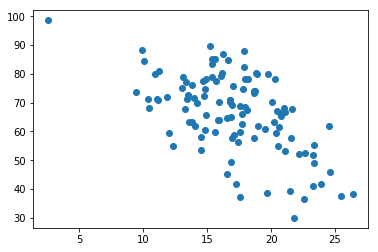

In [96]:
plt.plot(LongData.loc[(cul,irr),'AirTemperature'],
        LongData.loc[(cul,irr),'RelativeHumidity'],'o')

In [97]:
X = LongData.loc[(cul,irr),'AirTemperature']
Y = LongData.loc[(cul,irr),'RelativeHumidity']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeHumidity   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1963.
Date:                Tue, 16 Oct 2018   Prob (F-statistic):           1.26e-85
Time:                        14:22:19   Log-Likelihood:                -420.58
No. Observations:                 110   AIC:                             845.2
Df Residuals:                     108   BIC:                             850.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             99.6688      4.713     21.147      0.000      90.327     109.011
AirTemperature    -1.9526      0.269     -7.267      0.000      -2.485      -1.420
==============================================================================
Omnibus:                        1.750   Durbin-Watson:                   0.760
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.802
Skew:                          -0.283   Prob(JB):                        0.406
Kurtosis:                       2.731   Cond. No.                         77.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Air temperature and relative humidity are highly correlated so lets forget about humidity as air temperature is easier to deal with in a practical situation

## How much of the variation can AirTemp and fPAR account for on their own.

In [98]:
Descriptors = ['AirTemperature','RelativeHumidity','IncomingRadnMJ','Windspeed',
              'SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR','SoilRad']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDay   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     513.4
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          1.58e-208
Time:                        14:22:19   Log-Likelihood:                -22.418
No. Observations:                 376   AIC:                             64.84
Df Residuals:                     366   BIC:                             104.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.0633      0.339     -3.136      0.002      -1.730      -0.397
AirTemperature        0.0270      0.002     11.040      0.000       0.022       0.032
RelativeHumidity      0.0060      0.002      3.885      0.000       0.003       0.009
Windspeed            -0.0396      0.013     -3.008      0.003      -0.065      -0.014
IncomingRadnMJ        0.0300      0.003     10.870      0.000       0.025       0.035
fPAR                  0.1623      0.311      0.523      0.602      -0.448       0.773
SurfaceSoilTemp       0.0098      0.003      3.138      0.002       0.004       0.016
TempAirSoil1Diff      0.0172      0.003      5.900      0.000       0.011       0.023
SoilTemp15           -0.0004      0.006     -0.058      0.954      -0.013       0.012
TempAirSoil15Diff     0.0273      0.006      4.824      0.000       0.016       0.038
SoilWater            -0.7274      0.317     -2.295      0.022      -1.351      -0.104
SoilRad               0.0842      0.013      6.490      0.000       0.059       0.110
==============================================================================
Omnibus:                       11.032   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               20.025
Skew:                          -0.107   Prob(JB):                     4.48e-05
Kurtosis:                       4.110   Cond. No.                     1.51e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.91e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [99]:
Descriptors = ['AirTemperature',
               'IncomingRadnMJ',
               'fPAR']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDay   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1113.
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          1.76e-205
Time:                        14:22:19   Log-Likelihood:                -50.145
No. Observations:                 376   AIC:                             108.3
Df Residuals:                     372   BIC:                             124.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6561      0.078      8.360      0.000       0.502       0.810
AirTemperature     0.0500      0.004     12.485      0.000       0.042       0.058
IncomingRadnMJ     0.0318      0.002     15.406      0.000       0.028       0.036
fPAR              -1.7375      0.067    -25.908      0.000      -1.869      -1.606
==============================================================================
Omnibus:                        1.916   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.384   Jarque-Bera (JB):                1.791
Skew:                          -0.053   Prob(JB):                        0.408
Kurtosis:                       3.321   Cond. No.                         187.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
Descriptors = ['AirTemperature',
               'SoilRad']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDay   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     1161.
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          9.80e-189
Time:                        14:22:19   Log-Likelihood:                -92.791
No. Observations:                 376   AIC:                             191.6
Df Residuals:                     373   BIC:                             203.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6319      0.077     -8.216      0.000      -0.783      -0.481
AirTemperature     0.0659      0.004     15.850      0.000       0.058       0.074
SoilRad            0.0801      0.003     28.119      0.000       0.074       0.086
==============================================================================
Omnibus:                        2.260   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                2.207
Skew:                           0.187   Prob(JB):                        0.332
Kurtosis:                       2.981   Cond. No.                         86.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## R^2 of 0.93 with Radiation and fPAR and AirTemp and 0.931 with all others included.  No need to include the others!!!

In [101]:
# def estGDay(Radn, fPAR, AirTemp):
#     Const = 0.6306 
#     RadEff = np.multiply(Radn.values,0.0906)
#     fPAREff = np.multiply(fPAR, -1.733)
#     AirTempEff = np.multiply(AirTemp.values,0.0556)
#     return Const + RadEff + fPAREff + AirTempEff 
def estGDay(SoilRadn, AirTemp):
    Const = -0.7091
    SoilRadEff = np.multiply(SoilRadn.values,0.2149)
    AirTempEff = np.multiply(AirTemp.values,0.0736)
    return Const + SoilRadEff  + AirTempEff 

In [102]:
LongData.loc[:,'EstGDayMJ'] = estGDay(LongData.loc[:,'SoilRad'],
                                     LongData.loc[:,'AirTemperature'])

Text(0.0516327,2,'R^2 = 0.87\n Int = 0.30148\n Slope = 0.36193')

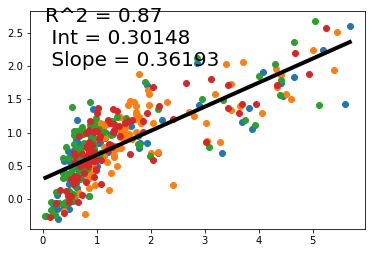

In [103]:
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'EstGDayMJ']
        plt.plot(Pred,Obs,'o')

X = LongData.loc[:,'EstGDayMJ']
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),2.,fitR2,fontsize=20)        


## Day time Soil heat flux can be modeled as 
GDay = 0.6306 + IncommingRadn * 0.0906 + fPAR * -1.733 + AirT * 0.0556

## Now we can estimate day time soil heat flux for all plots

In [104]:
DailyFPAR = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')

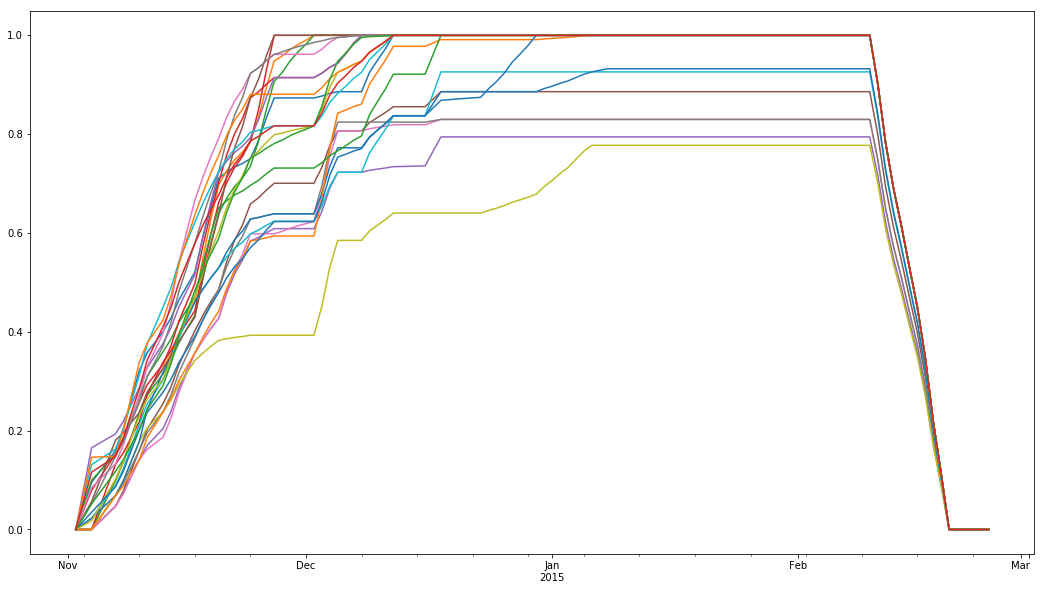

In [105]:
DailyFPAR.plot(legend=False,figsize=(18,10))

In [106]:
DayGEst = pd.DataFrame(index = DailyFPAR.index, columns = DailyFPAR.columns)
Radn = Data.loc[DaylightIndex,'IncomingRadnMJ'].resample('24h',base=6).sum()
Radn.index = Radn.index.normalize()
Temp = Data.loc[DaylightIndex, 'AirTemperature'].resample('24h', base=6).mean()
Temp.index = Temp.index.normalize()
for plot in DayGEst:
    DayGEst.loc[:,plot] = estGDay((1-DailyFPAR.loc[:,plot]) * Radn.loc[DailyFPAR.index,('Expt','Expt')],
                                 Temp.loc[DailyFPAR.index,('Expt','Expt')])

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [107]:
DayGEst.index.name='Date'

In [108]:
DayGEst.plot(figsize=(18,10), legend = False)

In [109]:
DayGEst.to_pickle('.\DataFrames\SoilHeatFluxDayEst.pkl')

## Have a look at Dark heat flux

In [110]:
DarkIndex = Data.IncomingRadnMJ.where(Data.IncomingRadnMJ<0.002)
DarkIndex.dropna(inplace=True)
DarkIndex = DarkIndex.index.tolist()

In [111]:
SoilHeatFluxMJNightMeans = SoilHeatFluxMJMeans.loc[DarkIndex,:].resample('24h',base=6).sum()
SoilHeatFluxMJNightMeans.index = SoilHeatFluxMJNightMeans.index.normalize()

GNight = SoilHeatFluxMJNightMeans.values

tup = ['GNight']
reps = [1,2,3]
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigs],names=['Measurement','Cultivar','Irrigation'])
GNightDF = pd.DataFrame(data = GNight, index = IncommingRadnDaylight.index, columns = NewIndex)
GNightDF.loc[pd.to_datetime(['2014-12-26 00:00:00',
                           '2014-12-27 00:00:00',
                           '2014-12-28 00:00:00',
                           '2015-02-12 00:00:00',
                           '2015-02-13 00:00:00',
                            '2015-02-14 00:00:00',
                            '2015-02-15 00:00:00',
                            '2015-02-16 00:00:00',
                            '2015-02-17 00:00:00',
                            '2015-02-18 00:00:00',
                            '2015-02-19 00:00:00',
                            '2015-02-20 00:00:00',
                            '2015-02-21 00:00:00',
                            '2015-02-22 00:00:00',
                            '2015-02-23 00:00:00',
                            '2015-02-24 00:00:00']),:] = np.nan
GNightDF.loc['2014-11-07':].plot(figsize=(18,10),style=['b--','r--','b-','r-'],)
GNightDF.loc['2014-12-1':'2014-12-7'].groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(figsize=(18,10),style=['b--','r--','b-','r-'])

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


ValueError: Shape of passed values is (4, 115), indices imply (4, 114)

In [ ]:
def SliceFullPlotsDark(CompleteData,Variable):
    Chunk = CompleteData.loc[:,Variable]
    NewIndex = pd.MultiIndex.from_product([Cultivars,['Low','Mid','High'],[1,2,3,4]],names=['Cultivar','Irrigation',''])
    Chunk.columns = NewIndex
    SubIndex = pd.MultiIndex.from_product([Cultivars,['Low','High'],[1,3,4]],names=['Cultivar','Irrigation',''])
    SubChunk = Chunk.loc[DarkIndex,SubIndex]
    SubChunkGroup = SubChunk.groupby(level=('Cultivar','Irrigation'), axis=1).mean()
    SubChunkAgregate = SubChunkGroup.resample('24h',base=6).mean()
    SubChunkAgregate.index = SubChunkAgregate.index.normalize()
    SubChunkUnstack = SubChunkAgregate.unstack()
    return SubChunkUnstack
    

In [ ]:
LongG = GNightDF.loc[:,('GNight')].unstack(0)
LongDataDark = pd.DataFrame(LongG, columns = ['GDark'])
for cul in Cultivars:
    for irr in IrrigationsShort:
        LongDataDark.loc[(cul,irr),'AirTemperature'] = Data.loc[DarkIndex,'AirTemperature'].resample('24h',base=6).mean().values
        LongDataDark.loc[(cul,irr),'RelativeHumidity'] = Data.loc[DarkIndex,'RelativeHumidity'].resample('24h',base=6).mean().values
        LongDataDark.loc[(cul,irr),'Windspeed'] = Data.loc[DarkIndex,'Windspeed'].resample('24h',base=6).mean().values
        LongDataDark.loc[(cul,irr),'IncomingRadnMJ'] = Data.loc[DarkIndex,'IncomingRadnMJ'].resample('24h',base=6).sum().values

LongDataDark.loc[:,'fPAR'] = CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().unstack()
LongDataDark.loc[:,'SurfaceSoilTemp'] = SliceFullPlots(Data,'SurfaceSoilTemp')
LongDataDark.loc[:,'TempAirSoil1Diff'] = LongDataDark.loc[:,'AirTemperature'] - SliceFullPlots(Data,'SurfaceSoilTemp') 
SubIndex = pd.MultiIndex.from_product([['TopTemp'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopTempDF.loc[DarkIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongDataDark.loc[:,'SoilTemp15'] = Temp.unstack()
LongDataDark.loc[:,'TempAirSoil15Diff'] = LongDataDark.loc[:,'AirTemperature'] - LongDataDark.loc[:,'SoilTemp15'] 
SubIndex = pd.MultiIndex.from_product([['TopWater'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopWaterDF.loc[DarkIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongDataDark.loc[:,'SoilWater'] = Temp.unstack()


In [ ]:
Graph = plt.figure(figsize=(18,60))
start = '2014-12-10'
end = '2015-02-10'
plt.figure(figsize=(18,10))
ecols = ['b','r','b','r']
fcols = ['w','w','b','r']
Irrigations = ['High','Low']
pannel = 1
Descriptors = ['AirTemperature','RelativeHumidity',
               'Windspeed','SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR']
for des in Descriptors:
    DailyDescriptor = LongDataDark.loc[:,des]
    fig = Graph.add_subplot(8,3,pannel)
    pos = 0
    for cul in Cultivars:
        for irr in Irrigations:
            fig.plot(LongDataDark.loc[(cul,irr),des].loc['2014-11-07':],
                LongDataDark.loc[(cul,irr),'GDark'].loc['2014-11-07':],
                     'o',mec=ecols[pos],mfc=fcols[pos],mew = 3, markersize = 12,)
            pos+=1  
    
    X = LongDataDark.loc[:,LongDataDark.columns.isin([des])]
    Y = LongDataDark.loc[:,'GDark']
    ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                            sm.add_constant(X), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
    Regres = ModTemp.fit(); 
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
    Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
    fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
    fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
    fig.text(X.min(),-0,fitR2,fontsize=20)
    fig.set_ylim(-2,0.5)
    fig.set_title(des, fontsize = 20)
    pannel +=1

In [ ]:
for cul in Cultivars:
    for irr in Irrigations:
        Day = LongData.loc[(cul,irr),'GDay']
        Night = LongDataDark.loc[(cul,irr),'GDark']
        plt.plot(Day,Night,'o')

X = LongData.loc[:,'GDay']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),2.,fitR2,fontsize=20)        


In [ ]:
Descriptors = ['AirTemperature','RelativeHumidity','IncomingRadnMJ','Windspeed',
              'SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR']
X = LongDataDark.loc[:,LongDataDark.columns.isin(Descriptors)]
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

In [ ]:
Descriptors = ['AirTemperature','fPAR']
X = LongDataDark.loc[:,LongDataDark.columns.isin(Descriptors)]
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

In [ ]:
def EstGDarkMJ(AirTemp,FPAR):
    Constant = -1.9157
    AirTempEff = np.multiply(AirTemp.values,0.0545)
    FPAREff = np.multiply(FPAR.values,0.666)  # 0.1% of the number of the beast   
    return Constant + AirTempEff + FPAREff

In [ ]:
LongDataDark.loc[:,'EstGDarkMJ'] = EstGDarkMJ(LongDataDark.loc[:,'AirTemperature'],
                                  LongDataDark.loc[:,'fPAR'])

In [ ]:
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongDataDark.loc[(cul,irr),'GDark']
        Pred = LongDataDark.loc[(cul,irr),'EstGDarkMJ']
        plt.plot(Pred,Obs,'o')

X = LongDataDark.loc[:,'EstGDarkMJ']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\nInt = ' + str(Regres.params[0])[:7] + '\nSlope = ' + str(Regres.params[1])[:7]
plt.text(X.min()-.2,-0.7,fitR2,fontsize=20)        


## Night time soil heat flux can be estimated by
 -1.9157 + AirT * 0.0545 + fPAR * 0.666
## So we can get an estimate of GNight for each plot

In [ ]:
NightGEst = pd.DataFrame(index = DailyFPAR.index, columns = DailyFPAR.columns)
Temp = Data.loc[DaylightIndex, 'AirTemperature'].resample('24h', base=6).mean()
Temp.index = Temp.index.normalize()
for plot in NightGEst:
    NightGEst.loc[:,plot] = EstGDarkMJ(Temp.loc[DailyFPAR.index,('Expt','Expt')],
                                     DailyFPAR.loc[:,plot])

In [ ]:
NightGEst.plot(figsize=(18,10),legend=False)

In [ ]:
NightGEst.to_pickle('.\DataFrames\SoilHeatfluxNightEst.pkl')

In [ ]:
Graph = plt.figure(figsize=(9,18))

Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
cultLines = ['--','--','-','-']
alphas = [0.2,0.3]

fig = Graph.add_subplot(2,1,2)
Pos =0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongDataDark.loc[(cul,irr),'GDark']
        Pred = LongDataDark.loc[(cul,irr),'EstGDarkMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1

X = LongDataDark.loc[:,'EstGDarkMJ']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Xs = [-1.8,-0.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)
plt.ylabel('$G_{nightEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{nightObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.90'
plt.text(-1.95,-0.25,fitR2,fontsize=20)  
model = '$G_{nightEst} = -1.916 + 0.666 fPAR + 0.054 T_a$'
plt.text(-1.95, -0.1,model,fontsize=20)

fig = Graph.add_subplot(2,1,1)
Pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'EstGDayMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1
        
Xs = [-.2,2.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)   
plt.ylabel('$G_{dayEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{dayObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.93' 
#plt.text(-0.4,2.5,fitR2,fontsize=20) 
model = '$G_{dayEst} = 0.71 + 0.21R_s(1-fPAR) + 0.073 T_a$'
#plt.text(-0.4, 2.8,model,fontsize=20)

In [ ]:
Graph = plt.figure(figsize=(18,14))
Shape = (2,14)
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
cultLines = ['--','--','-','-']
alphas = [0.2,0.3]

fig = plt.subplot2grid(Shape,(0,0),colspan=8)#Graph.add_subplot(2,1,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.index
        Med = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,cultLines[CulPos],color=irrigColors[IrrPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.xlim('2014-11-1','2015-02-15')
plt.ylim(-3,38)
plt.ylabel('$\Sigma G$ $(MJ/m^2)$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-11-3',34,'(a)',fontsize=16)

fig = plt.subplot2grid(Shape,(1,0),colspan=8)#Graph.add_subplot(2,1,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1

CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'s',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(-3,3)
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$G$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-11-3',2.6,'(b)',fontsize=16)
plt.text('2014-12-30', 2,'Day',fontsize=16)
plt.text('2014-12-30', -2,'Night',fontsize=16)

fig = plt.subplot2grid(Shape,(0,9),colspan=5)#Graph.add_subplot(2,1,2)
Pos =0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongDataDark.loc[(cul,irr),'GDark']
        Pred = LongDataDark.loc[(cul,irr),'EstGDarkMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1

X = LongDataDark.loc[:,'EstGDarkMJ']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Xs = [-1.8,-0.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)
plt.ylabel('$G_{nightEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{nightObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.90'
#plt.text(-1.95,-0.25,fitR2,fontsize=20)  
model = '$G_{nightEst} = -1.916 + 0.666 fPAR + 0.054 T_a$'
#plt.text(-1.95, -0.1,model,fontsize=20)
plt.text(-1.95,-.2,'(c)',fontsize=16)

fig = plt.subplot2grid(Shape,(1,9),colspan=5)#Graph.add_subplot(2,1,1)
Pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'EstGDayMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1
        
Xs = [-.2,2.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)   
plt.ylabel('$G_{dayEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{dayObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.93' 
#plt.text(-0.4,2.5,fitR2,fontsize=20) 
model = '$G_{dayEst} = 0.631 + 0.091 R - 1.734 fPAR + 0.056 T_a$'
#plt.text(-0.4, 2.8,model,fontsize=20)
plt.text(-0.4,2.7,'(d)',fontsize=16)

In [ ]:
Graph = plt.figure(figsize=(5.6,6))
Shape = (2,14)
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
cultLines = ['--','--','-','-']
gaps = [3,3,0.0001,0.0001]
alphas = [0.2,0.3]

fig = Graph.add_subplot(2,1,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.index
        Med = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,cultLines[CulPos],color=irrigColors[IrrPos],label = Cul + ' ' + Irr,dashes=(3,gaps[CulPos]))
        IrrPos += 1
        CulPos+=1
plt.xlim('2014-11-1','2015-02-15')
plt.ylim(-3,38)
plt.ylabel('$\Sigma G$ $(MJ/m^2)$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=6)    
plt.text('2014-11-3',35,'a',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
       
fig = Graph.add_subplot(2,1,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,markersize=3,color = irrigColors[IrrPos],dashes=(3,gaps[CulPos]))
        IrrPos += 1
        CulPos+=1

CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'s',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,markersize=3,color = irrigColors[IrrPos],dashes=(3,gaps[CulPos]))
        IrrPos += 1
        CulPos+=1
plt.ylim(-3,3)
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$G$ $(MJ/m^2/d)$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=6)    
plt.text('2014-11-3',2.6,'b',fontsize=7)
plt.text('2014-12-30', 2,'Day',fontsize=7)
plt.text('2014-12-30', -2,'Night',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
       
Graph.savefig('Fig_4.jpg',dpi=1000)

In [ ]:
Pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'IncomingRadnMJ']
        plt.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1
plt.plot([0,])